In [30]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU,Conv1D,MaxPooling1D
from keras.layers import Bidirectional, GlobalMaxPool1D,Bidirectional
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
import gc
from sklearn.model_selection import train_test_split
from keras.models import load_model

In [31]:
img_table_and_df = pd.read_csv('img_table_and_df.csv')
img_table_and_df

,Unnamed: 0,0
0,0,adidas-y-3-tangutsu-blue
1,1,adidas-ozweego-model-pack
2,2,adidas-eqt-guidance-93-sneakersnstuff-tee-time
3,3,adidas-350-black-orange-yellow
4,4,adidas-nmd-xr1-winter-olive
...,...,...
3852,3852,adidas-campus-80s-undftd-x-bape-black
3853,3853,adidas-nite-jogger-ash-silver
3854,3854,adidas-continental-vulc-arizona-mucho-mango
3855,3855,adidas-zx-8000-bravo-fall-of-the-wall


In [32]:
model_name = img_table_and_df['0']
model_name

0                             adidas-y-3-tangutsu-blue
1                            adidas-ozweego-model-pack
2       adidas-eqt-guidance-93-sneakersnstuff-tee-time
3                       adidas-350-black-orange-yellow
4                          adidas-nmd-xr1-winter-olive
                             ...                      
3852             adidas-campus-80s-undftd-x-bape-black
3853                     adidas-nite-jogger-ash-silver
3854       adidas-continental-vulc-arizona-mucho-mango
3855             adidas-zx-8000-bravo-fall-of-the-wall
3856         adidas-palace-pro-boost-bright-cyan-white
Name: 0, Length: 3857, dtype: object

In [33]:
max_features = 20000

#num_words: 利用する単語の最大数
#char_level: Trueなら，全文字はトークンとして扱われる
tokenizer = Tokenizer(num_words=max_features,char_level=True)

In [34]:
tokenizer.fit_on_texts(list(model_name))

In [35]:
list_tokenized = tokenizer.texts_to_sequences(model_name)


In [36]:
list_tokenized[1]

[2,
 3,
 5,
 3,
 2,
 6,
 1,
 8,
 26,
 20,
 4,
 4,
 18,
 8,
 1,
 17,
 8,
 3,
 4,
 10,
 1,
 16,
 2,
 12,
 19]

In [37]:
len(list_tokenized[1])

25

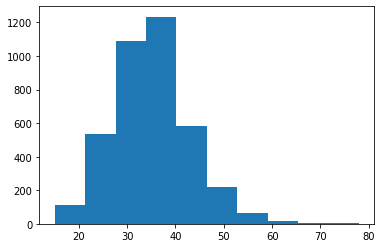

In [38]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized]
plt.hist(totalNumWords)
plt.show()

In [39]:
maxlen = 80

#maxlen: シーケンスの最大長
X = pad_sequences(list_tokenized, maxlen=maxlen)

In [40]:
X.shape

(3857, 80)

In [41]:
#Functional API
#入力
inp = Input(shape=(maxlen, ))

In [42]:
embed_size = 240
x = Embedding(len(tokenizer.word_index)+1, embed_size)(inp)

In [43]:
#padding="same"は元の入力と同じ長さを出力がもつように入力にパディング
x = Conv1D(filters=100,kernel_size=4,padding='same', activation='relu')(x)

In [44]:
x=MaxPooling1D(pool_size=4)(x)

In [45]:
x = Bidirectional(GRU(60, return_sequences=True,name='lstm_layer',dropout=0.2,recurrent_dropout=0.2))(x)

In [46]:
x = GlobalMaxPool1D()(x)

In [47]:
x = Dense(50, activation="relu", name='hidden')(x)

In [48]:
x = Dropout(0.2)(x)
x = Dense(6, activation="sigmoid")(x)

In [49]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                 metrics=['accuracy'])

In [50]:
layer_name = 'hidden'
hidden_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

In [51]:
hidden = hidden_model.predict(X)

In [52]:
hidden.shape

(3857, 50)

In [53]:
hidden[0]

array([0.006766  , 0.00357047, 0.03548574, 0.        , 0.        ,
       0.        , 0.01786484, 0.01736344, 0.0483926 , 0.04672828,
       0.00607488, 0.        , 0.        , 0.        , 0.01102154,
       0.01458548, 0.        , 0.02299069, 0.01377428, 0.        ,
       0.02396342, 0.03165712, 0.00611734, 0.        , 0.        ,
       0.02177036, 0.05636359, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.05783948, 0.01754637, 0.00546824,
       0.        , 0.02313876, 0.        , 0.01924209, 0.        ,
       0.        , 0.00239997, 0.00824227, 0.        , 0.02197992,
       0.0537254 , 0.        , 0.0932835 , 0.        , 0.03892338],
      dtype=float32)

In [54]:
text_df = pd.DataFrame(hidden)

In [55]:
text_df

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.006766,0.003570,0.035486,0.0,0.000000,0.0,0.017865,0.017363,0.048393,0.046728,...,0.0,0.002400,0.008242,0.0,0.021980,0.053725,0.000000,0.093283,0.0,0.038923
1,0.005924,0.000000,0.042771,0.0,0.020802,0.0,0.031773,0.024191,0.055172,0.041448,...,0.0,0.017244,0.008178,0.0,0.021961,0.046389,0.001855,0.098536,0.0,0.037625
2,0.010980,0.001262,0.031979,0.0,0.000000,0.0,0.034049,0.028495,0.042032,0.036677,...,0.0,0.025078,0.011959,0.0,0.025578,0.044574,0.000000,0.116931,0.0,0.038318
3,0.012158,0.000000,0.028007,0.0,0.003673,0.0,0.033711,0.000385,0.046874,0.042791,...,0.0,0.010298,0.008763,0.0,0.023895,0.057756,0.000000,0.102914,0.0,0.037376
4,0.011140,0.005086,0.042293,0.0,0.000000,0.0,0.031453,0.017611,0.050807,0.051470,...,0.0,0.010768,0.012109,0.0,0.025311,0.067979,0.008095,0.096651,0.0,0.037344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3852,0.017947,0.001047,0.034016,0.0,0.000000,0.0,0.034017,0.022957,0.039387,0.044179,...,0.0,0.017322,0.020873,0.0,0.022673,0.068652,0.001736,0.108122,0.0,0.038541
3853,0.018535,0.002730,0.032983,0.0,0.000000,0.0,0.033209,0.020961,0.041813,0.035633,...,0.0,0.021620,0.015635,0.0,0.025159,0.047623,0.005036,0.097769,0.0,0.030457
3854,0.016253,0.002448,0.051086,0.0,0.002763,0.0,0.030348,0.012993,0.047906,0.034063,...,0.0,0.011226,0.007243,0.0,0.018939,0.051124,0.000000,0.107364,0.0,0.048138
3855,0.023732,0.009663,0.043393,0.0,0.000000,0.0,0.042819,0.030830,0.048365,0.037084,...,0.0,0.011318,0.008912,0.0,0.027552,0.051083,0.013368,0.113749,0.0,0.044774


In [56]:
text_df.to_csv('text_df.csv')

In [57]:
maxlen = 80

#maxlen: シーケンスの最大長
X = pad_sequences(list_tokenized, maxlen=maxlen)
#Functional API
#入力
inp = Input(shape=(maxlen, ))
embed_size = 480
x = Embedding(len(tokenizer.word_index)+1, embed_size)(inp)
#padding="same"は元の入力と同じ長さを出力がもつように入力にパディング
x = Conv1D(filters=360,kernel_size=4,padding='same', activation='relu')(x)
x=MaxPooling1D(pool_size=4)(x)
x = Bidirectional(GRU(300, return_sequences=True,name='lstm_layer',dropout=0.2,recurrent_dropout=0.2))(x)
x = GlobalMaxPool1D()(x)
x = Dense(256, activation="relu", name='hidden')(x)
x = Dropout(0.2)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                 metrics=['accuracy'])
layer_name = 'hidden'
hidden_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
hidden = hidden_model.predict(X)
print(hidden.shape)
text_df = pd.DataFrame(hidden)
text_df.to_csv('text_df_256.csv')

(3857, 256)


In [58]:
maxlen = 80

#maxlen: シーケンスの最大長
X = pad_sequences(list_tokenized, maxlen=maxlen)
#Functional API
#入力
inp = Input(shape=(maxlen, ))
embed_size = 480
x = Embedding(len(tokenizer.word_index)+1, embed_size)(inp)
#padding="same"は元の入力と同じ長さを出力がもつように入力にパディング
x = Conv1D(filters=360,kernel_size=4,padding='same', activation='relu')(x)
x=MaxPooling1D(pool_size=4)(x)
x = Bidirectional(GRU(300, return_sequences=True,name='lstm_layer',dropout=0.2,recurrent_dropout=0.2))(x)
x = GlobalMaxPool1D()(x)
x = Dense(128, activation="relu", name='hidden')(x)
x = Dropout(0.2)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                 metrics=['accuracy'])
layer_name = 'hidden'
hidden_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
hidden = hidden_model.predict(X)
print(hidden.shape)
text_df = pd.DataFrame(hidden)
text_df.to_csv('text_df_128.csv')

(3857, 128)


In [59]:
maxlen = 80

#maxlen: シーケンスの最大長
X = pad_sequences(list_tokenized, maxlen=maxlen)
#Functional API
#入力
inp = Input(shape=(maxlen, ))
embed_size = 480
x = Embedding(len(tokenizer.word_index)+1, embed_size)(inp)
#padding="same"は元の入力と同じ長さを出力がもつように入力にパディング
x = Conv1D(filters=360,kernel_size=4,padding='same', activation='relu')(x)
x=MaxPooling1D(pool_size=4)(x)
x = Bidirectional(GRU(300, return_sequences=True,name='lstm_layer',dropout=0.2,recurrent_dropout=0.2))(x)
x = GlobalMaxPool1D()(x)
x = Dense(64, activation="relu", name='hidden')(x)
x = Dropout(0.2)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                 metrics=['accuracy'])
layer_name = 'hidden'
hidden_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
hidden = hidden_model.predict(X)
print(hidden.shape)
text_df = pd.DataFrame(hidden)
text_df.to_csv('text_df_64.csv')

(3857, 64)


定価の変換

In [72]:
adidas_final_df = pd.read_csv('adidas_final_df.csv')
price = adidas_final_df['retail_price']
price = price.to_numpy()
price.shape

(3857,)

In [84]:
# This returns a tensor
inputs = Input(shape=(1,))

# a layer instance is callable on a tensor, and returns a tensor
x = Dense(256, activation='relu')(inputs)
x = Dense(256, activation='relu', name='hidden')(x)
predictions = Dense(10, activation='softmax')(x)

# This creates a model that includes
# the Input layer and three Dense layers
model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# model.fit(data, labels)  # starts training
layer_name = 'hidden'
hidden_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
hidden = hidden_model.predict(price)
print(hidden.shape)
price_256_df = pd.DataFrame(hidden)
price_256_df.to_csv('price_256_df.csv')

(3857, 256)


In [85]:
price_256_df

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,387.940796,1568.011719,0.0,5732.013184,675.016113,368.750366,0.0,0.0,0.0,0.0,...,0.0,2675.383057,0.0,0.0,1256.444214,0.0,2085.079590,0.0,1202.668335,0.0
1,232.764603,940.807251,0.0,3439.208252,405.010071,221.250214,0.0,0.0,0.0,0.0,...,0.0,1605.229980,0.0,0.0,753.866394,0.0,1251.047607,0.0,721.601196,0.0
2,201.729370,815.366089,0.0,2980.646973,351.008453,191.750092,0.0,0.0,0.0,0.0,...,0.0,1391.199097,0.0,0.0,653.350830,0.0,1084.241333,0.0,625.387756,0.0
3,170.694046,689.925049,0.0,2522.085938,297.007050,162.250214,0.0,0.0,0.0,0.0,...,0.0,1177.168457,0.0,0.0,552.835449,0.0,917.434937,0.0,529.174194,0.0
4,279.317535,1128.968262,0.0,4127.049805,486.011902,265.500427,0.0,0.0,0.0,0.0,...,0.0,1926.276001,0.0,0.0,904.639709,0.0,1501.257202,0.0,865.921631,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3852,279.317566,1128.968140,0.0,4127.051270,486.011780,265.500458,0.0,0.0,0.0,0.0,...,0.0,1926.276367,0.0,0.0,904.639709,0.0,1501.256592,0.0,865.921082,0.0
3853,263.799805,1066.248413,0.0,3897.770020,459.011200,250.750244,0.0,0.0,0.0,0.0,...,0.0,1819.260742,0.0,0.0,854.382202,0.0,1417.853760,0.0,817.814575,0.0
3854,77.588203,313.602386,0.0,1146.402832,135.003250,73.750038,0.0,0.0,0.0,0.0,...,0.0,535.076721,0.0,0.0,251.288925,0.0,417.015961,0.0,240.533737,0.0
3855,201.729431,815.366028,0.0,2980.646973,351.008453,191.750427,0.0,0.0,0.0,0.0,...,0.0,1391.199341,0.0,0.0,653.350769,0.0,1084.241699,0.0,625.387756,0.0


In [94]:
sum(price_256_df.iloc[0] == 0)

130

In [ ]:
# This returns a tensor
inputs = Input(shape=(1,))

# a layer instance is callable on a tensor, and returns a tensor
x = Dense(128, activation='relu')(inputs)
x = Dense(128, activation='relu', name='hidden')(x)
predictions = Dense(10, activation='softmax')(x)

# This creates a model that includes
# the Input layer and three Dense layers
model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# model.fit(data, labels)  # starts training
layer_name = 'hidden'
hidden_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
hidden = hidden_model.predict(price)
print(hidden.shape)
price_128_df = pd.DataFrame(hidden)
price_128_df.to_csv('price_128_df.csv')

In [87]:
price_128_df

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,572.096252,0.0,0.0,3421.782715,0.0,1052.165894,1670.576294,0.0,1372.245728,1114.296265,...,0.0,1551.298340,4877.411621,5147.373047,0.0,1360.798096,0.0,0.0,0.0,1692.894653
1,343.257721,0.0,0.0,2053.069336,0.0,631.299561,1002.345703,0.0,823.347046,668.577820,...,0.0,930.779053,2926.446533,3088.423828,0.0,816.478577,0.0,0.0,0.0,1015.736938
2,297.489868,0.0,0.0,1779.326538,0.0,547.126404,868.699585,0.0,713.567566,579.433960,...,0.0,806.675110,2536.253906,2676.634521,0.0,707.614807,0.0,0.0,0.0,880.305298
3,251.722168,0.0,0.0,1505.583862,0.0,462.953094,735.052917,0.0,603.787842,490.290344,...,0.0,682.571228,2146.060791,2264.844238,0.0,598.751038,0.0,0.0,0.0,744.873840
4,411.908997,0.0,0.0,2463.683105,0.0,757.559509,1202.814941,0.0,988.016479,802.293274,...,0.0,1116.935059,3511.735840,3706.109375,0.0,979.774597,0.0,0.0,0.0,1218.884277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3852,411.908997,0.0,0.0,2463.683105,0.0,757.559509,1202.814941,0.0,988.016479,802.293274,...,0.0,1116.935059,3511.735840,3706.109375,0.0,979.774597,0.0,0.0,0.0,1218.884277
3853,389.025269,0.0,0.0,2326.811768,0.0,715.472839,1135.991455,0.0,933.126831,757.721436,...,0.0,1054.882935,3316.639648,3500.214600,0.0,925.342712,0.0,0.0,0.0,1151.168457
3854,114.419235,0.0,0.0,684.356445,0.0,210.433258,334.115112,0.0,274.449097,222.859177,...,0.0,310.259674,975.482422,1029.474854,0.0,272.159546,0.0,0.0,0.0,338.578979
3855,297.489868,0.0,0.0,1779.326538,0.0,547.126404,868.699585,0.0,713.567566,579.433960,...,0.0,806.675110,2536.253906,2676.634521,0.0,707.614807,0.0,0.0,0.0,880.305298


In [95]:
sum(price_128_df.iloc[0] == 0)

76

In [88]:
# This returns a tensor
inputs = Input(shape=(1,))

# a layer instance is callable on a tensor, and returns a tensor
x = Dense(64, activation='relu')(inputs)
x = Dense(64, activation='relu', name='hidden')(x)
predictions = Dense(10, activation='softmax')(x)

# This creates a model that includes
# the Input layer and three Dense layers
model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# model.fit(data, labels)  # starts training
layer_name = 'hidden'
hidden_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
hidden = hidden_model.predict(price)
print(hidden.shape)
price_64_df = pd.DataFrame(hidden)
price_64_df.to_csv('price_64_df.csv')

(3857, 64)


In [89]:
price_64_df

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,431.429932,0.0,0.0,1566.665894,0.0,0.0,2670.625488,0.0,0.0,440.851807,...,4303.538574,199.047424,1987.484009,5920.949707,0.0,3436.038818,0.0,1685.670166,0.0,0.0
1,258.858032,0.0,0.0,940.000061,0.0,0.0,1602.375244,0.0,0.0,264.511017,...,2582.123291,119.428459,1192.490112,3552.569824,0.0,2061.623047,0.0,1011.402161,0.0,0.0
2,224.343552,0.0,0.0,814.666443,0.0,0.0,1388.725220,0.0,0.0,229.242859,...,2237.839844,103.504601,1033.491455,3078.893799,0.0,1786.739990,0.0,876.548157,0.0,0.0
3,189.829208,0.0,0.0,689.333069,0.0,0.0,1175.075073,0.0,0.0,193.974701,...,1893.557251,87.580856,874.492920,2605.218018,0.0,1511.857178,0.0,741.694824,0.0,0.0
4,310.629395,0.0,0.0,1127.999634,0.0,0.0,1922.850464,0.0,0.0,317.413269,...,3098.547852,143.314270,1430.988403,4263.084473,0.0,2473.947754,0.0,1213.682617,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3852,310.629395,0.0,0.0,1127.999634,0.0,0.0,1922.850464,0.0,0.0,317.413269,...,3098.547852,143.314270,1430.988403,4263.084473,0.0,2473.947754,0.0,1213.682617,0.0,0.0
3853,293.372223,0.0,0.0,1065.332764,0.0,0.0,1816.025391,0.0,0.0,299.779205,...,2926.406738,135.352356,1351.488770,4026.246338,0.0,2336.506348,0.0,1146.255737,0.0,0.0
3854,86.285950,0.0,0.0,313.333313,0.0,0.0,534.125183,0.0,0.0,88.170380,...,860.707764,39.809536,397.496796,1184.189819,0.0,687.207764,0.0,337.133942,0.0,0.0
3855,224.343552,0.0,0.0,814.666443,0.0,0.0,1388.725220,0.0,0.0,229.242859,...,2237.839844,103.504601,1033.491455,3078.893799,0.0,1786.739990,0.0,876.548157,0.0,0.0


In [96]:
sum(price_64_df.iloc[0] == 0)

26